In [1]:
# This code is used to overlap simulated light curve and 
# Kepler Lightcurve

In [2]:
# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model
import math
import sys


2023-10-10 14:32:02.080841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 14:32:02.959639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


# Load kepler light curves

In [3]:
filenames = ['../data/tfr_shallue/tfr_all/tfrecord/train-00000-of-00008',
             '../data/tfr_shallue/tfr_all/tfrecord/train-00001-of-00008',
             '../data/tfr_shallue/tfr_all/tfrecord/train-00002-of-00008',
             '../data/tfr_shallue/tfr_all/tfrecord/train-00003-of-00008',
             '../data/tfr_shallue/tfr_all/tfrecord/train-00004-of-00008',
             '../data/tfr_shallue/tfr_all/tfrecord/train-00005-of-00008',
             '../data/tfr_shallue/tfr_all/tfrecord/train-00006-of-00008',
             '../data/tfr_shallue/tfr_all/tfrecord/train-00007-of-00008',
             '../data/tfr_shallue/tfr_all/tfrecord/val-00000-of-00001',
             '../data/tfr_shallue/tfr_all/tfrecord/test-00000-of-00001']
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

feature_description = {
    'global_view': tf.io.FixedLenSequenceFeature([], tf.float32, default_value=0.0,allow_missing=True),
    'local_view': tf.io.FixedLenSequenceFeature([], tf.float32, default_value=0.0,allow_missing=True),
    'av_training_set': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'kepid': tf.io.FixedLenSequenceFeature([], tf.int64, default_value=int(0),allow_missing=True),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

# At this point the dataset contains serialized tf.train.Example messages.
# When iterated over it returns these as scalar string tensors.
# Use the .take method to only show the first 10 records.
for raw_record in raw_dataset.take(10):
  print(repr(raw_record))
  
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset


# Calculate the size of one light curve corresponding to 'local_view'
y = np.array([])
for elem in parsed_dataset.take(1):
  y = np.append(y,[elem['local_view']])
length_lc = len(y)
print("length_lc = " ,length_lc)


# Calculate total number of light curves
no_data = 0
for elem in parsed_dataset.as_numpy_iterator():
    no_data = no_data + 1
print('no_data = ',no_data)

# Extract Kepler ID
kepid_array = np.zeros(shape=(no_data,))
i = 0
for elem in parsed_dataset:
    kepid_array[i] = elem['kepid'] 
    i = i + 1

# lc_label_array - array containing labels
lc_label_array = np.chararray(shape=(no_data,))

i = 0
for elem in parsed_dataset.as_numpy_iterator():
    lc_label_array[i] = elem['av_training_set']
    i = i + 1

# convert all tf dataset to np array (light curve numpy array (lc_np_array))
lc_np_array = np.zeros(shape=(no_data,length_lc))
lc_np_array.shape

i = 0
for elem in parsed_dataset.as_numpy_iterator():
    lc_np_array[i] = elem['local_view'] #+1.0
    i = i + 1

print('lc_np_array[0] = ',lc_np_array[0])


2023-10-10 14:32:06.098806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30937 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-10-10 14:32:07.005866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]
2023-10-10 14:32:07.073204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]


<tf.Tensor: shape=(), dtype=string, numpy=b'\n\xdbG\n\x15\n\x0ctce_plnt_num\x12\x05\x1a\x03\n\x01\x02\n\x19\n\x0fav_training_set\x12\x06\n\x04\n\x02PC\n\x1b\n\x0ftce_max_mult_ev\x12\x08\x12\x06\n\x04H\xe1\x06B\n\x1a\n\x0espline_bkspace\x12\x08\x12\x06\n\x04\x9a\xa97@\n\x17\n\rav_pred_class\x12\x06\n\x04\n\x02PC\n\x15\n\ttce_depth\x12\x08\x12\x06\n\x043\x13PD\n\x16\n\ntce_impact\x12\x08\x12\x06\n\x04\x94\xf66?\n\x19\n\rtce_model_snr\x12\x08\x12\x06\n\x04\x14\xae\x02B\n\x14\n\x08tce_prad\x12\x08\x12\x06\n\x04\xecQ@@\n\x17\n\x0btce_time0bk\x12\x08\x12\x06\n\x04\x17\x193C\n\xda>\n\x0bglobal_view\x12\xca>\x12\xc7>\n\xc4>\x8a\x99\xbc<\xde\x8f\x9c\xbdl\xf5l<(s\r=o\x1f\xe8\xba\t\xcf\xbd\xbcG\n\xc2\xbc"\x1f\x17\xbc\xfd&\xd1\xbc\x15w*=f\xa1v\xbc\xea\x95\xf0\xbci\xcb\xf1<\x00\x00\x00\x00g6t\xbd\x1f\xf5\x9b=\xabg\x87<]\xc5\x1d=.\xc7\x83<\\0\xa0\xbd\xb0&\x00>\x98\xd6\xa6<\x96A)\xbcb\x84\x96\xbd\xb6)\xaa\xbd)\x08\x8b\xbc\x1c\x1cm>\xab\x16\xbb=}\\R=\xf3\x13b\xbc\x02\xe6\xc9\xbdg6t\xbd\x93\x17\xae\xbc

2023-10-10 14:32:07.110122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]


no_data =  15737
lc_np_array[0] =  [-6.92397356e-02 -2.56392676e-02 -4.75080535e-02 -6.34126291e-02
 -2.86556520e-02 -7.22561181e-02 -7.22561181e-02  1.56303551e-02
  3.60595062e-02  5.99163622e-02  5.51175699e-02 -4.38746847e-02
  6.16987748e-03  4.48344424e-02  2.11146921e-02  1.93322822e-02
  4.11325163e-04 -4.53828759e-02 -5.10728732e-02 -5.02502210e-02
 -3.57852876e-02 -9.18626133e-03  3.29060107e-02  5.47062457e-02
 -7.54096126e-03  1.37108378e-04  2.26228833e-02  2.57763769e-02
  1.12977311e-01  9.85809267e-02  7.41756335e-02  3.29060107e-02
 -7.87687674e-02  2.42681839e-02  1.53561393e-02  8.08939431e-03
 -1.70014389e-02 -8.80235806e-02 -7.41756335e-02 -7.97970816e-02
 -5.81339560e-02 -2.64619179e-02 -3.08493860e-02  2.33084261e-02
 -3.53739634e-02 -3.53739634e-02  1.37108390e-03  1.09686712e-02
 -1.68643314e-02  1.72756556e-02  1.87838487e-02  1.87838487e-02
  2.60505918e-03  6.95139542e-02 -4.53828759e-02 -6.64975643e-02
  6.71831099e-03 -4.66168523e-02 -2.87927613e-02 -5.539

7115530


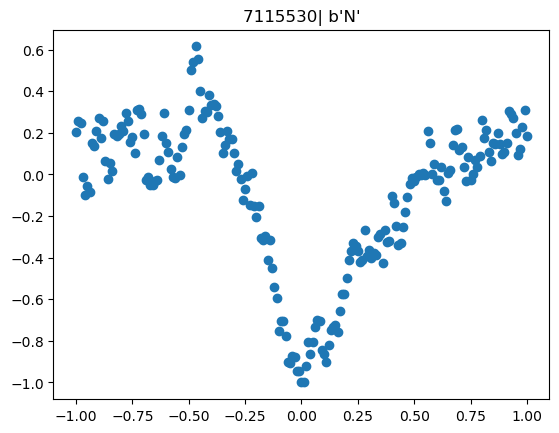

In [4]:
for i in np.arange(1):
    j=981
    test_lc = lc_np_array[j]
    ph = np.linspace(-1.0,1.0,len(lc_np_array[0]))
    plt.scatter(ph, test_lc)
    print(int(kepid_array[j]))
    plt.title(f"{int(kepid_array[j])}| {lc_label_array[j]}")
    plt.show()

In [5]:
# Code to select all the index of Kepler light curves with SNR > 50

# Calculate SNR of all the lc in Kepler Dataset
lc_np_array_offset = lc_np_array + 1
noise_array = np.zeros((len(lc_np_array),120))
for i in np.arange(len(lc_np_array)):
    noise_array[i][0:60] = lc_np_array[i,0:60]
    noise_array[i][60:120] = lc_np_array[i,141:202]
std_devs_Kepler = np.array([np.std(arr) for arr in noise_array])
SNR_Kepler = 1/std_devs_Kepler


In [6]:
# Code to show the properties of the light curves in Kepler Dataset
print(f"Total no. of light curves in Kepler Dataset = ",len(SNR_Kepler))
print("\tTotal No. of planets = ",len(np.where(lc_label_array==b'P')[0]))
print("\tTotal no. of non-transiting phenomenon = ",len(np.where(lc_label_array==b'N')[0]))
print("\tTotal no. of astrophysical false positive = ",len(np.where(lc_label_array==b'A')[0]))
print("\n---\n")
SNR_Threshold_array = [50,75,100,500]
for SNR_Threshold in SNR_Threshold_array:
    selected_kepler_index_mask = SNR_Kepler > SNR_Threshold
    selected_kepler_index = np.where(selected_kepler_index_mask)[0]
    print(f"For SNR >  {SNR_Threshold}")
    print(f"\tNo. of light curves = ",len(selected_kepler_index))
    # print("Index where label = Planet: ",np.where(lc_label_array[selected_kepler_index]==b'P')[0])
    print("\tNo. of planets = ",len(np.where(lc_label_array[selected_kepler_index]==b'P')[0]))
    print("\tNo. of non-transiting phenomenon = ",len(np.where(lc_label_array[selected_kepler_index]==b'N')[0]))
    print("\tNo. of astrophysical false positive = ",len(np.where(lc_label_array[selected_kepler_index]==b'A')[0]))

    # print('selected_kepler_index_mask = ',selected_kepler_index_mask)
    # print('selected_kepler_index = ',selected_kepler_index)
    

Total no. of light curves in Kepler Dataset =  15737
	Total No. of planets =  3600
	Total no. of non-transiting phenomenon =  2541
	Total no. of astrophysical false positive =  9596

---

For SNR >  50
	No. of light curves =  1952
	No. of planets =  364
	No. of non-transiting phenomenon =  21
	No. of astrophysical false positive =  1567
For SNR >  75
	No. of light curves =  1681
	No. of planets =  256
	No. of non-transiting phenomenon =  17
	No. of astrophysical false positive =  1408
For SNR >  100
	No. of light curves =  1530
	No. of planets =  206
	No. of non-transiting phenomenon =  16
	No. of astrophysical false positive =  1308


No. of light curves with SNR > 500 =  912
Total no. of light curves =  15737


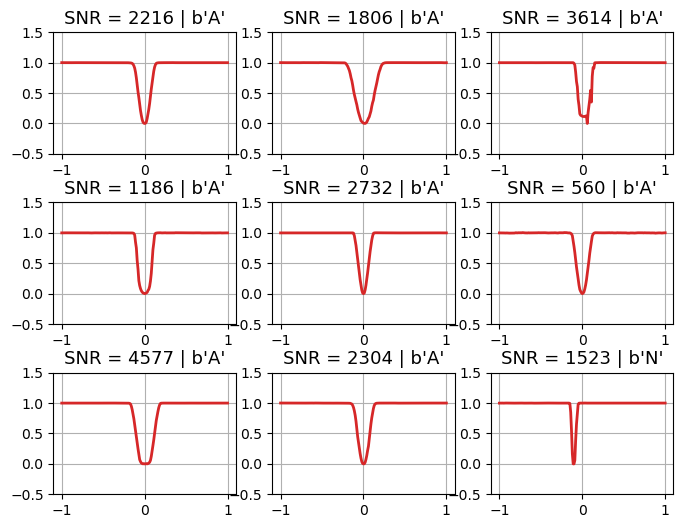

In [7]:
# Save the index of the light curve with SNR > 50
# select_kepler_lc = lc_np_array[SNR_Kepler>75]
# select_kepler_lc = select_kepler_lc + 1

SNR_Threshold = 500
selected_kepler_index_mask = (SNR_Kepler > SNR_Threshold)  # & (SNR_Kepler < 500) 
selected_kepler_index = np.where(selected_kepler_index_mask)[0]
print(f"No. of light curves with SNR > {SNR_Threshold} = ",len(selected_kepler_index))
print(f"Total no. of light curves = ",len(SNR_Kepler))
# Plot the selected light curves 3 x 3
num = 3
fig,ax=plt.subplots(num,3, figsize=(8,6), gridspec_kw={ 'width_ratios': [1,1,1],
        'wspace': 0.2,'hspace': 0.4})

# ax[0][1].set_title('Shape',size=15)
# ax[0][0].set_title('Light Curve (Train Dataset)',size=15)
# ax[num-1][0].set_xlabel('Phase',size=13)
ph_kepler = np.linspace(-1,1,len(lc_np_array_offset[0]))


i = 0
for i in np.arange(0,num):
    # k = np.random.randint(0, len(select_kepler_lc)-50)
    k = int(np.random.choice(selected_kepler_index))
    ax[i][0].set_title(f'SNR = {int(np.round(SNR_Kepler[k],0))} | {lc_label_array[k]}',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].plot(ph_kepler, lc_np_array_offset[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')

    k = int(np.random.choice(selected_kepler_index))
    ax[i][1].set_title(f'SNR = {int(np.round(SNR_Kepler[k],0))} | {lc_label_array[k]}',size=13)
    ax[i][1].set_ylim(-0.5,1.5)
    ax[i][1].plot(ph_kepler, lc_np_array_offset[k],color = 'tab:red',linewidth='2')
    ax[i][1].grid('on')

    k = int(np.random.choice(selected_kepler_index))
    ax[i][2].set_title(f'SNR = {int(np.round(SNR_Kepler[k],0))} | {lc_label_array[k]}',size=13)
    ax[i][2].set_ylim(-0.5,1.5)
    ax[i][2].plot(ph_kepler, lc_np_array_offset[k],color = 'tab:red',linewidth='2')
    ax[i][2].grid('on')
    i = i + 1

np.where(ph_kepler == 0)[0] =  [100]
len(ph_kepler) =  201
np.sum(a) =  15737


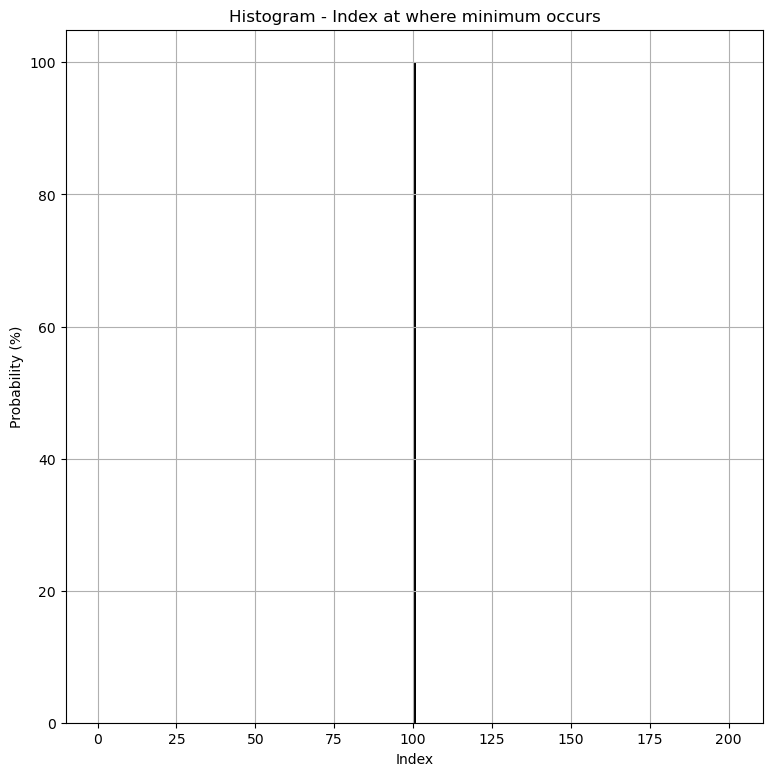

In [8]:
## Code to shift the light curve to the centre

# Check whether any index for phase axis phase is 0
print('np.where(ph_kepler == 0)[0] = ', np.where(ph_kepler == 0)[0]) # OP: np.where(ph == 0)[0] =  [100]
print('len(ph_kepler) = ',len(ph_kepler)) # OP: len(ph) =  201

# Calculate the index where light curve is at minimum and shift it
min_index = np.zeros(len(lc_np_array_offset))
for iter in np.arange(len(lc_np_array_offset)):
    min_index[iter] = np.argmin(lc_np_array_offset[iter])
    # Calculate the number of positions to shift the array
    shift_amount = len(lc_np_array_offset[iter]) // 2 - min_index[iter]

    # Shift the array to bring the minimum value to the central index
    lc_np_array_offset[iter] = np.roll(lc_np_array_offset[iter], int(shift_amount))
    min_index[iter] = np.argmin(lc_np_array_offset[iter])

# Plot the histogram of the index
bins = np.linspace(0,201,202)

plt.figure(figsize=(9, 9))
# plt.hist(std_devs_Kepler, bins=bins, density=True, alpha=0.8, color='tab:green')
a,*_ = np.histogram(min_index, bins=bins)
# print('a = ',a)
print('np.sum(a) = ', np.sum(a))
a_percent = (a/np.sum(a))*100
# print('a_percent = ',a_percent)

plt.stairs(a_percent, bins, baseline=0,fill=True,color='black')
plt.xlabel('Index')
# plt.xscale("log")
plt.ylabel('Probability (%)')
plt.title('Histogram - Index at where minimum occurs')
plt.grid(True)
plt.show()



Total no. of light curves =  15737


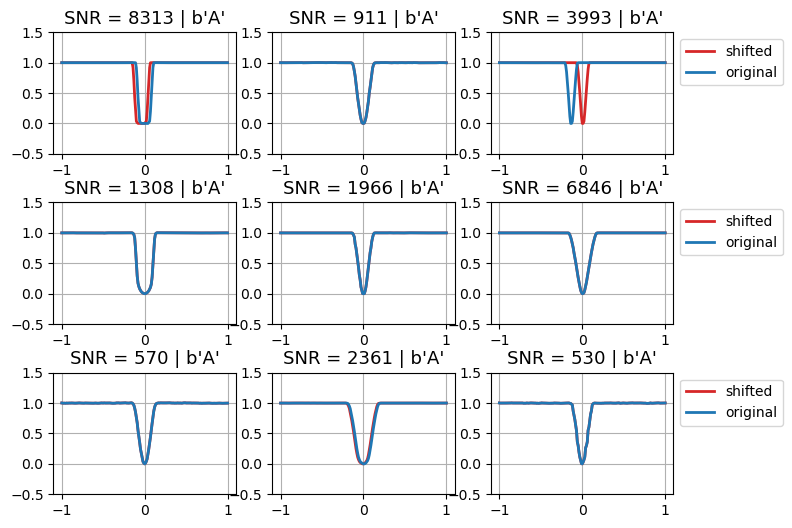

In [9]:
# To plot the shifted lightcurves

print(f"Total no. of light curves = ",len(SNR_Kepler))
# Plot the selected light curves 3 x 3
num = 3
fig,ax=plt.subplots(num,3, figsize=(8,6), gridspec_kw={ 'width_ratios': [1,1,1],
        'wspace': 0.2,'hspace': 0.4})

# ax[0][1].set_title('Shape',size=15)
# ax[0][0].set_title('Light Curve (Train Dataset)',size=15)
# ax[num-1][0].set_xlabel('Phase',size=13)
ph_kepler = np.linspace(-1,1,len(lc_np_array_offset[0]))


i = 0
for i in np.arange(0,num):
    # k = np.random.randint(0, len(select_kepler_lc)-50)
    k = int(np.random.choice(selected_kepler_index))
    ax[i][0].set_title(f'SNR = {int(np.round(SNR_Kepler[k],0))} | {lc_label_array[k]}',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].plot(ph_kepler, lc_np_array_offset[k],color = 'tab:red',label='shifted',linewidth='2')
    ax[i][0].plot(ph_kepler, lc_np_array[k]+1,color = 'tab:blue',label='original',linewidth='2')
    ax[i][0].grid('on')
#     ax[i][0].legend()


    k = int(np.random.choice(selected_kepler_index))
    ax[i][1].set_title(f'SNR = {int(np.round(SNR_Kepler[k],0))} | {lc_label_array[k]}',size=13)
    ax[i][1].set_ylim(-0.5,1.5)
    ax[i][1].plot(ph_kepler, lc_np_array_offset[k],color = 'tab:red',label='shifted',linewidth='2')
    ax[i][1].plot(ph_kepler, lc_np_array[k]+1,color = 'tab:blue',label='original',linewidth='2')
    ax[i][1].grid('on')
#     ax[i][1].legend()


    k = int(np.random.choice(selected_kepler_index))
    ax[i][2].set_title(f'SNR = {int(np.round(SNR_Kepler[k],0))} | {lc_label_array[k]}',size=13)
    ax[i][2].set_ylim(-0.5,1.5)
    ax[i][2].plot(ph_kepler, lc_np_array_offset[k],color = 'tab:red',label='shifted',linewidth='2')
    ax[i][2].plot(ph_kepler, lc_np_array[k]+1,color = 'tab:blue',label='original',linewidth='2')
    ax[i][2].grid('on')
    ax[i][2].legend(loc='upper left', bbox_to_anchor=(1, 1))

    i = i + 1

np.sum(a) =  15617


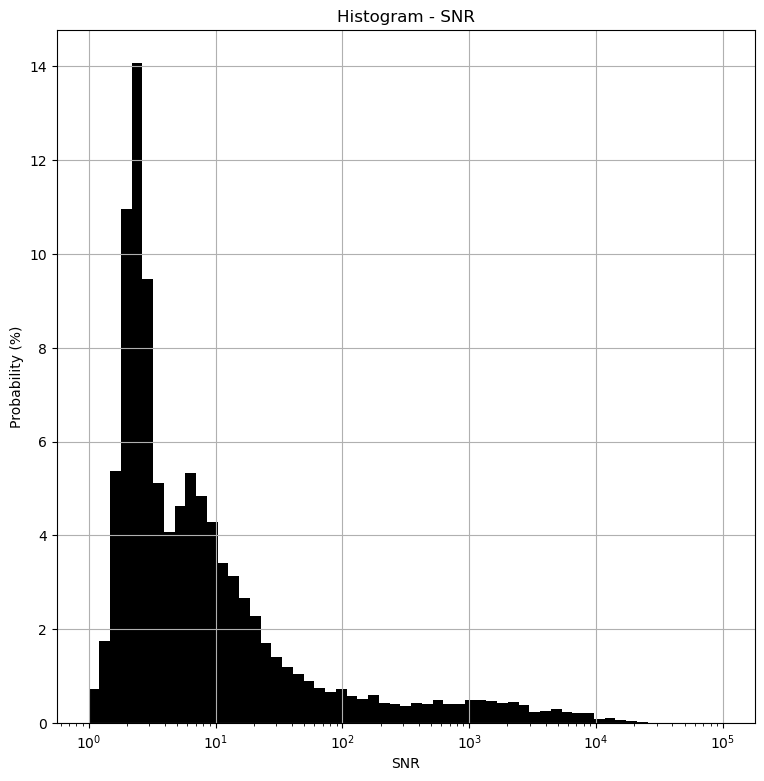

In [10]:
bins = np.logspace(0,5,60)

plt.figure(figsize=(9, 9))
# plt.hist(std_devs_Kepler, bins=bins, density=True, alpha=0.8, color='tab:green')
a,*_ = np.histogram(SNR_Kepler, bins=bins)
# print('a = ',a)
print('np.sum(a) = ', np.sum(a))
a_percent = (a/np.sum(a))*100
# print('a_percent = ',a_percent)

plt.stairs(a_percent, bins, baseline=0,fill=True,color='black')
plt.xlabel('SNR')
plt.xscale("log")
plt.ylabel('Probability (%)')
plt.title('Histogram - SNR')
plt.grid(True)
plt.show()

# Load simulation light curves

In [11]:
# 1. Load Dataset
## Load Train Set
train_shape_dir = '../data/data_npy/shape_npy/shape_filled5.npy'
train_lc_dir = '../data/data_npy/lc_npy/lc_dict_5.npy'
train_lc = np.load(train_lc_dir)
train_shape = np.load(train_shape_dir)
# Check equality of number of dataset
if len(train_lc)==len(train_shape):
    print("Train Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: Train Set: No. of LC != No. of shapes")

## Load Validation Set
vald_shape_dir = '../data/data_npy/shape_npy/shape_filled4.npy'
vald_lc_dir = '../data/data_npy/lc_npy/lc_dict_4.npy'
vald_lc = np.load(vald_lc_dir)
vald_shape = np.load(vald_shape_dir)
# Check equality of nuftmber of dataset
if len(vald_lc)==len(vald_shape):
    print("Vald Set: No. of LC = No. of shapes")
else:
    sys.exit("Vald Set: No. of LC = No. of shapes")

Train Set: No. of LC = No. of shapes
Vald Set: No. of LC = No. of shapes


In [12]:
# 2. Normalize the image, convert to opacity map
## Train Set
train_shape = train_shape/np.amax(train_shape)
train_shape_where_0 = np.where(train_shape == 0)
train_shape_where_1 = np.where(train_shape == 1)
train_shape[train_shape_where_0] = 1  # 1 represent the shape (1 opacity)
train_shape[train_shape_where_1] = 0  # 0 represent background (0 opacity)

## Valdn Set
vald_shape = vald_shape/np.amax(vald_shape)
vald_shape_where_0 = np.where(vald_shape == 0)
vald_shape_where_1 = np.where(vald_shape == 1)
vald_shape[vald_shape_where_0] = 1  # 1 represent the shape (1 opacity)
vald_shape[vald_shape_where_1] = 0  # 0 represent background (0 opacity)
print("Normalized the shape")


Normalized the shape


In [13]:
# 2. Normalize the lightcurves
## - Train Set
train_lc_scaled = np.zeros(train_lc.shape)
for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled[i] = (train_lc[i] - np.amin(train_lc[i]))/(np.amax(train_lc[i]) - np.amin(train_lc[i]))

## - Vald Set
vald_lc_scaled = np.zeros(vald_lc.shape)
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled[i] = (vald_lc[i] - np.amin(vald_lc[i]))/(np.amax(vald_lc[i]) - np.amin(vald_lc[i]))
print("Normalized the light curves")


Normalized the light curves


In [14]:
# Add flat line towards left and right of dip
# 10 data points on each side
# 3. Extend the lightcurves
## - Train Set
train_lc_scaled_append = np.ones((train_lc.shape[0],120))
print('train_lc_scaled_append.shape = ',train_lc_scaled_append.shape)
print("len(train_lc_scaled_append[0,10:110]) = ",len(train_lc_scaled_append[0,10:110]))

for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled_append[i,10:110] = train_lc_scaled[i]

## - Vald Set
vald_lc_scaled_append = np.ones((vald_lc.shape[0],120))
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled_append[i,10:110] = vald_lc_scaled[i]
print("Extended the light curves")

train_lc_scaled_append.shape =  (132136, 120)
len(train_lc_scaled_append[0,10:110]) =  100
Extended the light curves


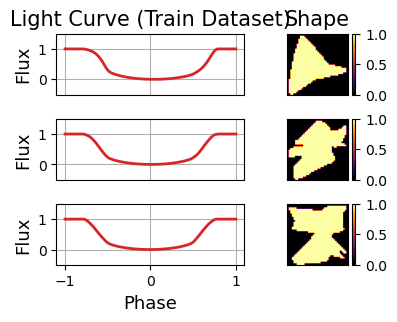

In [15]:
# Verification
# Plot - Train LCs
num = 3
fig,ax=plt.subplots(num,2, figsize=(4,3), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve (Train Dataset)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph_simul = np.linspace(-1,1,len(train_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = np.random.randint(0, len(train_lc_scaled_append)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(train_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
#     ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph_simul, train_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1

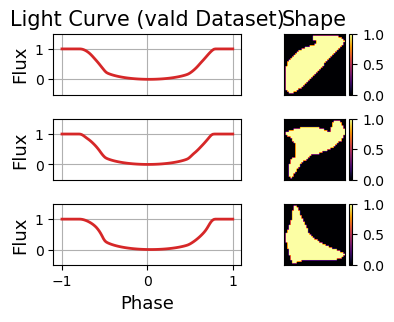

In [16]:
# Verification
# Plot - vald LCs
num = 3
fig,ax=plt.subplots(num,2, figsize=(4,3), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve (vald Dataset)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(vald_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = np.random.randint(0, len(vald_lc_scaled_append)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(vald_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
#     ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph_simul, vald_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1

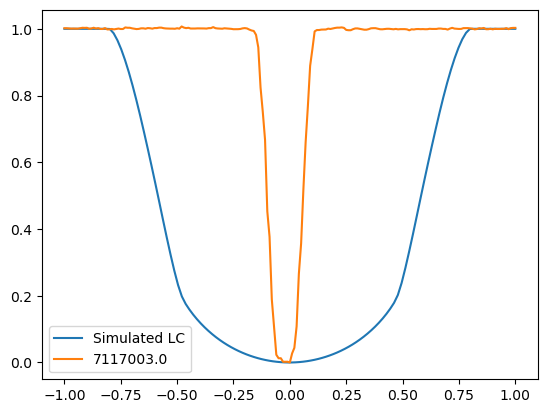

In [17]:
plt.plot(ph_simul,train_lc_scaled_append[0],label='Simulated LC')
plt.plot(ph_kepler,lc_np_array_offset[selected_kepler_index[0]],label=f"{kepid_array[selected_kepler_index[0]]}")
plt.legend()
plt.show()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

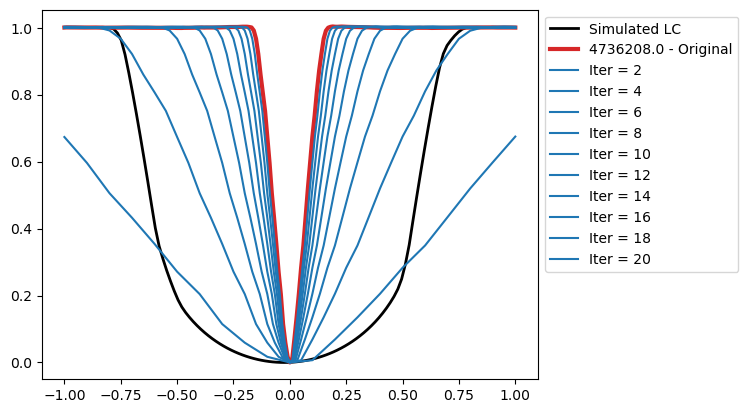

In [58]:
plt.plot(ph_simul,train_lc_scaled_append[29],label='Simulated LC',linewidth=2,color='black')
kep_id_scale = int(np.random.choice(selected_kepler_index))

for iter in np.linspace(0,20,20,dtype=int):
    
    start_index = (iter*5)
    stop_index = len(lc_np_array_offset[kep_id_scale]) - (iter*5)
    lc_scale_test = lc_np_array_offset[kep_id_scale][start_index:stop_index]
    ph_kepler_scale = np.linspace(-1,1,len(lc_scale_test))
    if iter == 0:
        plt.plot(ph_kepler_scale,lc_scale_test,label=f"{kepid_array[kep_id_scale]} - Original",color='tab:red',linewidth=3)
    elif iter%2==0:
        plt.plot(ph_kepler_scale,lc_scale_test,label=f"Iter = {iter}",color='tab:blue')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()